### Import section

In [2]:
import numpy as np
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns

from skimage import color
from skimage.feature import hog

In [3]:
import warnings
import itertools
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# !pip install visualkeras
import tensorflow as tf
#import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
#from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# General parameters

epochs = 15
pic_size = 240
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# pip install opencv-python
import cv2
import os

folder_path = "/kaggle/input/Training"             # base/root directory

no_tumor = os.listdir(folder_path + '/notumor/')
glioma = os.listdir(folder_path + '/glioma/')
meningioma = os.listdir(folder_path + '/meningioma/')
pituitary = os.listdir(folder_path + '/pituitary/')


# no_tumor, glioma, meningioma, pituitary, craniopharyngioma

dataset=[]
lab=[]

In [7]:
for image_name in no_tumor:
    image=cv2.imread(folder_path + '/notumor/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

In [8]:
for image_name in glioma:
    image=cv2.imread(folder_path + '/glioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [9]:
for image_name in meningioma:
    image=cv2.imread(folder_path + '/meningioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)

In [10]:
for image_name in pituitary:
    image=cv2.imread(folder_path + '/pituitary/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [11]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(5712, 240, 240, 3) (5712,)


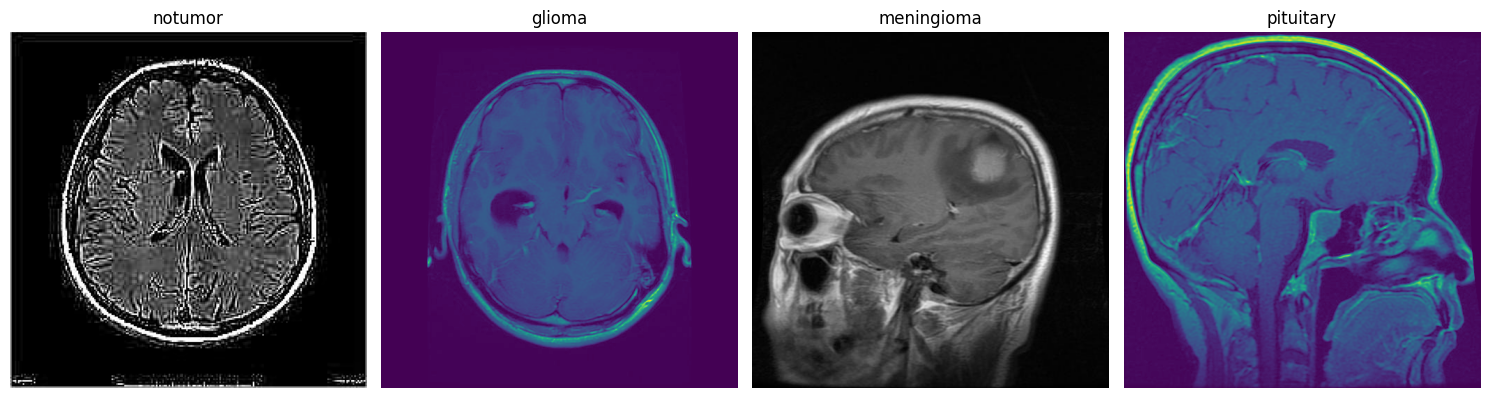

In [12]:
import random
import matplotlib.image as mpimg

image_directories = ['notumor', 'glioma', 'meningioma', 'pituitary']

num_images = len(image_directories)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Loop through each directory
for i, directory in enumerate(image_directories):
    image_files = os.listdir(os.path.join("/kaggle/input/Training", directory))
    random_image_file = random.choice(image_files)
    image_path = os.path.join("/kaggle/input/Training", directory, random_image_file)  # Get random image in the directory
    
    # Load and plot the image
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axes
    axes[i].set_title(directory)  # Set title to the directory name

# Adjust layout spacing
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

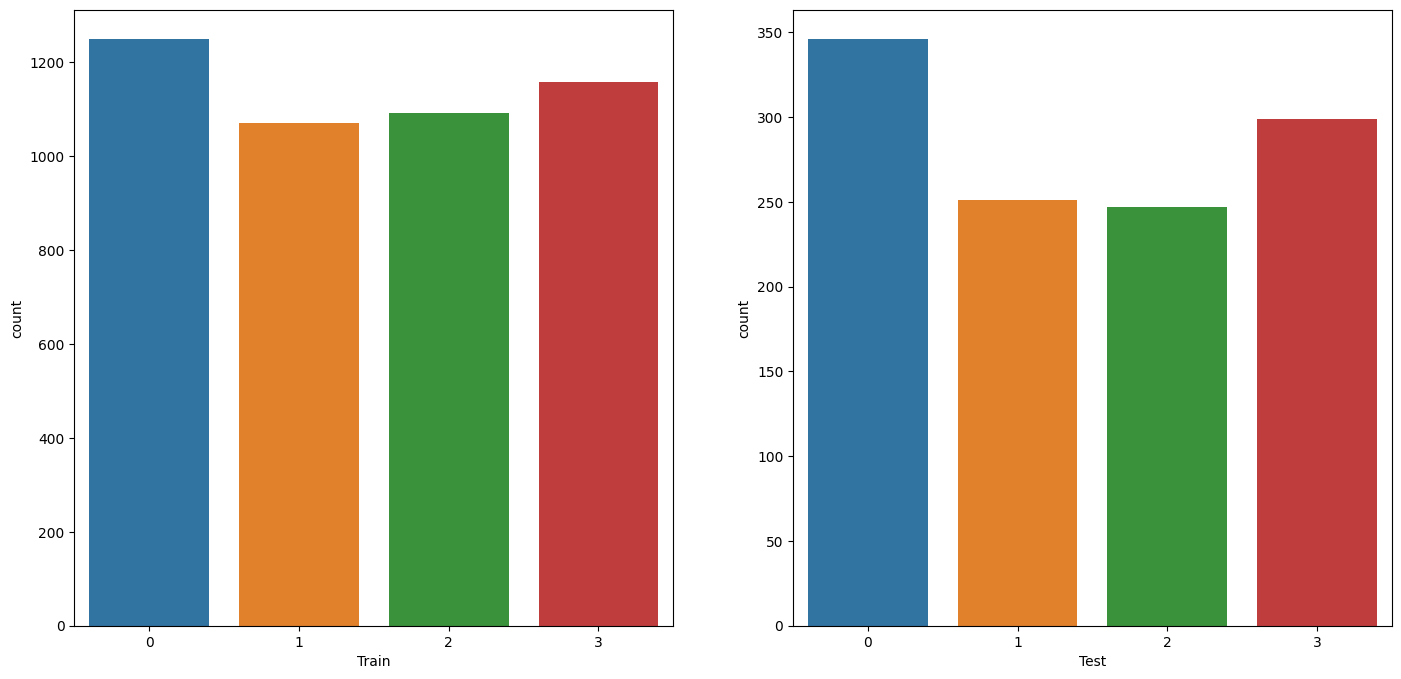

In [14]:
# import seaborn as sns

plt.figure(figsize = (17,8))

lis = ['Train', 'Test']
for i,j in enumerate([y_train, y_test]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [15]:
print('Training data and target sizes: \n{}, {}'.format(x_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(x_test.shape,y_test.shape))

Training data and target sizes: 
(4569, 240, 240, 3), (4569,)
Test data and target sizes: 
(1143, 240, 240, 3), (1143,)


In [16]:
# Count occurrences of each label in y_train and y_test
train_label_counts = np.bincount(y_train)
test_label_counts = np.bincount(y_test)

# Print the label counts
for label, count in enumerate(train_label_counts):
    print(f"Train Label {label}: {count} occurrences")

print("\n")

for label, count in enumerate(test_label_counts):
    print(f"Test Label {label}: {count} occurrences")

Train Label 0: 1249 occurrences
Train Label 1: 1070 occurrences
Train Label 2: 1092 occurrences
Train Label 3: 1158 occurrences


Test Label 0: 346 occurrences
Test Label 1: 251 occurrences
Test Label 2: 247 occurrences
Test Label 3: 299 occurrences


In [17]:
# X_train_scaled = x_train / 255
# X_test_scaled = x_test / 255

In [18]:
# # One hot encoding
# y_train_encoded = pd.get_dummies(y_train)
# y_test_encoded = pd.get_dummies(y_test)

In [19]:
import cv2
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss (or 'val_accuracy' for accuracy)
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True,  # Restore model to the best state
    verbose=1            # Print messages when stopping
)

folder_path = "/kaggle/input/Training"

# List subdirectories
subdirectories = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Load images and labels
dataset = []
lab = []

for label, subdirectory in enumerate(subdirectories):
    subdirectory_path = os.path.join(folder_path, subdirectory)
    image_names = os.listdir(subdirectory_path)
    
    for image_name in image_names:
        image_path = os.path.join(subdirectory_path, image_name)
        image = cv2.imread(image_path)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((299, 299))  # InceptionV3 expects 299x299 input
        dataset.append(np.array(image))
        lab.append(label)

dataset = np.array(dataset)
lab = np.array(lab)

# Preprocess input images
dataset = preprocess_input(dataset)

# One-hot encode labels
lab_onehot = to_categorical(lab, num_classes=len(subdirectories))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, lab_onehot, test_size=0.2, random_state=42)

# Load pre-trained InceptionV3 model (Fully Frozen Feature Extractor)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(len(subdirectories), activation='softmax')(x)  # Output layer

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 353ms/step - accuracy: 0.6554 - loss: 75.6589 - val_accuracy: 0.7874 - val_loss: 8.5069
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.8843 - loss: 3.3230 - val_accuracy: 0.7962 - val_loss: 6.4473
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.9023 - loss: 1.9041 - val_accuracy: 0.7699 - val_loss: 3.1602
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 0.9298 - loss: 0.9273 - val_accuracy: 0.9256 - val_loss: 0.9868
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.9528 - loss: 0.4151 - val_accuracy: 0.9195 - val_loss: 0.7061
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.9662 - loss: 0.2646 - val_accuracy: 0.9423 - val_loss: 0.7655
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 0.9835 - loss: 0.1418 - val_accuracy: 0.9344 - val_loss: 0.9107
Epoch 8/20
143/143 ━━━━━━━━━━━━

In [20]:
model.save("brain_tumor_InceptionV3_Full.h5")

In [21]:
results = model.evaluate(X_test, y_test)
print('The current model achieved an accuracy of {}%!'.format(round(results[1]*100,2)))

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9347 - loss: 1.9713
The current model achieved an accuracy of 93.7%!


In [22]:
from sklearn.metrics import classification_report

# Predict labels on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Get class names
class_names = ['no_tumor', 'glioma', 'meningioma', 'pituitary']

# Generate classification report
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Print classification report
print(classification_rep)

36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step
              precision    recall  f1-score   support

    no_tumor       0.99      0.98      0.99       346
      glioma       1.00      0.80      0.89       251
  meningioma       0.79      0.98      0.87       247
   pituitary       0.99      0.96      0.97       299

    accuracy                           0.94      1143
   macro avg       0.94      0.93      0.93      1143
weighted avg       0.95      0.94      0.94      1143



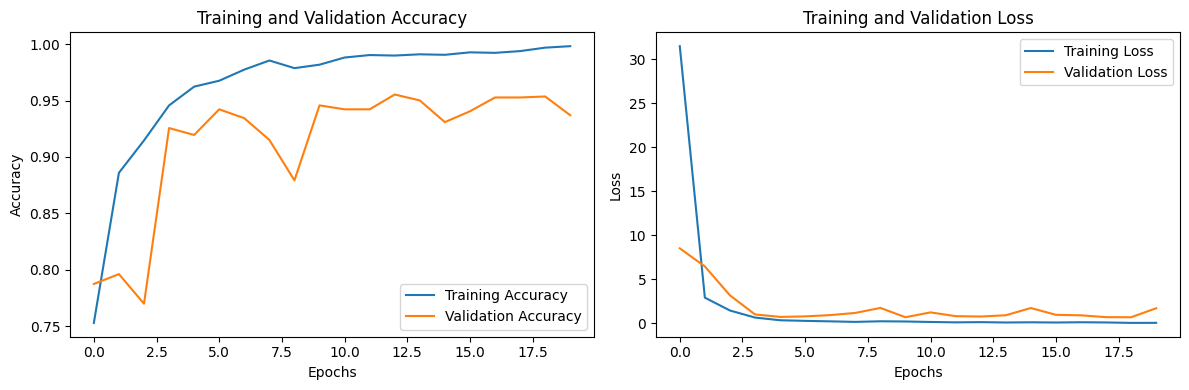

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import r2_score
r2_score(y_true_classes, y_pred_classes)

0.9369888842237499

In [25]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary'])

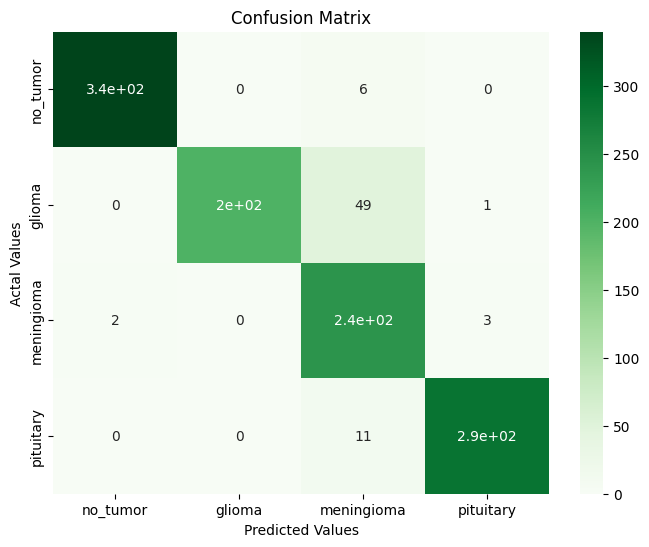

In [26]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [27]:
model.save("brain_tumor_InceptionV3_Full.h5")

In [29]:
import shutil

# Specify the file or folder to download
output_file = "/kaggle/working/brain_tumor_InceptionV3_Full.h5"  # Change to your filename

# Compress the file (optional, if large)
shutil.make_archive(output_file, 'zip', output_file)

# Provide a download link
from IPython.display import FileLink
FileLink(f"{output_file}.zip")

/kaggle/working/brain_tumor_InceptionV3_Full.h5.zip

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step


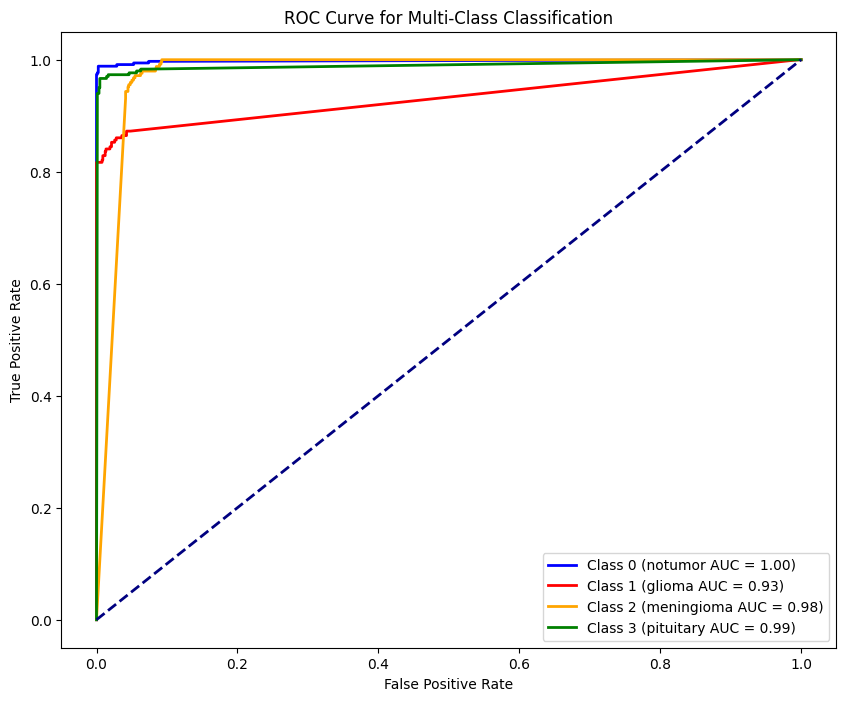

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['notumor', 'glioma', 'meningioma', 'pituitary']

y_true = y_test
raw_predictions = model.predict(X_test)
# Use softmax to convert raw predictions to probabilities
y_prob = scipy.special.softmax(raw_predictions, axis=-1)

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(4))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(4):  # Assuming 5 classes
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green']  # Add more colors if needed

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()